In [15]:
#%% Import library
import pyodbc
import pandas as pd
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV

In [16]:
#%% Connect Database
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=AAA-DBSRV1;'
                      'Database=AAAeAuction;'
                      'Trusted_Connection=yes;')

In [9]:
#%% Data Queries
cursor = conn.cursor()
cursor.execute('''
SELECT 
               t1.CompanyCode,
               t1.ItemCode,
               t1.BrandCode,b.BrandNameEng, --MoveSequence
               t1.ModelCode,im.ModelName, --MoveSequence 
               t1.SubModelCode,ism.SubModelName, --MoveSequence
               t1.CustSubModelCode,CSM.CustSubModelName, -- NewField
               ISNULL(t1.LicensePlateNo,'') AS LicensePlateNo,
               t1.ColorCode,dc.Color, -- MoveSequence
               t1.EngineCode,
               t1.GearCode,ig.GearName, --MoveSequence
               t1.GearType,igt.GearTypeName, -- NewField
               t1.ManufactureYear,
               t1.ReceiveMiles,
               t1.StockMiles,
               t1.ReceivedWareHouseCode,
               t2.DamageDesc,
               inspec.inspectionDesc,
               iq.QualityDesc,
               iq.QualityType,
               iq.Quality,
               p.ItemAuctionStatus,
               p.OpeningPrice,
               p.SoldPrice,
               p.UpdatedDate,
               p.CreatedDate,
               p.SoldToBuyerCode,CONCAT(BB.FirstName,BB.MidName,BB.LastName) SoldToBuyerName, -- NewField
               ibd.BodyName,
               t1.CcID,icc.CcName
FROM InGoods t1
               INNER JOIN MiInspection inspec WITH(NOLOCK) ON inspec.CompanyCode = t1.CompanyCode  
                                               AND inspec.ItemCode = t1.ItemCode    
                                               AND inspec.Status = 'S' 
               INNER JOIN MiGoods t2 WITH(NOLOCK) ON t1.ItemCode = t2.ItemCode
               INNER JOIN AuAuctionItem p WITH(NOLOCK) ON p.CompanyCode = t2.CompanyCode   
                                          AND p.ItemCode = t2.ItemCode
               LEFT JOIN DbBrand b  WITH(NOLOCK) ON b.BrandCode = t1.BrandCode 
               LEFT JOIN InModel im  WITH(NOLOCK) ON im.BrandCode = t1.BrandCode   
                                    AND im.ModelCode = t1.ModelCode
               LEFT JOIN InSubModel ism WITH(NOLOCK) 
               ON ism.BrandCode = t1.BrandCode   
                                    AND ism.ModelCode = t1.ModelCode
                                    AND ism.SubModelCode = t1.SubModelCode
               LEFT JOIN InQuality iq WITH(NOLOCK) ON iq.CompanyCode = t1.CompanyCode  
                                    AND iq.QualityCode = t1.QualityCode
               LEFT JOIN InBody ibd WITH(NOLOCK) ON ibd.CompanyCode = t1.CompanyCode   
                                    AND ibd.BodyCode = t1.BodyCode
               LEFT JOIN InCc icc WITH(NOLOCK) ON icc.CompanyCode = t1.CompanyCode 
                                    AND icc.CcID = t1.CcID
                                    AND icc.ProductCategoryCode = t1.ProductCategoryCode
               LEFT JOIN InGear ig WITH(NOLOCK) ON ig.GearCode = t1.GearCode
               LEFT JOIN DbColor dc WITH(NOLOCK) ON dc.ColorCode = t1.ColorCode

               INNER JOIN InGearType igt with(nolock) on t1.GearType = igt.GearType 
               INNER JOIN InCustomerSubModel CSM WITH(NOLOCK) ON t1.CustSubModelCode = CSM.CustSubModelCode
               INNER JOIN ByBuyer  BB WITH(NOLOCK) ON p.SoldToBuyerCode = BB.BuyerCode''')

In [17]:
cursor.execute('''SELECT t1.CompanyCode,
t1.ItemCode,
t1.BrandCode,b.BrandNameEng, --MoveSequence
t1.ModelCode,im.ModelName, --MoveSequence 
t1.SubModelCode,ism.SubModelName, --MoveSequence
t1.CustSubModelCode,CSM.CustSubModelName, -- NewField
ISNULL(t1.LicensePlateNo,'') AS LicensePlateNo,
t1.ReceivedWareHouseCode AS WareHouse,
t1.ColorCode,dc.Color, -- MoveSequence
t1.EngineCode,
t1.GearCode,ig.GearName, --MoveSequence
t1.GearType,igt.GearTypeName AS drive, -- NewField
t1.ManufactureYear AS ManuYear,
t1.ReceiveMiles,
t2.DamageDesc,
inspec.inspectionDesc,
q.QualityDesc,
q.QualityType,
q.Quality AS ExQuality ,
iq.Quality AS InQuality,
p.ItemAuctionStatus,
p.OpeningPrice,
p.SoldPrice,
p.UpdatedDate,
p.CreatedDate,
p.SoldToBuyerCode,CONCAT(BB.FirstName,BB.MidName,BB.LastName) SoldToBuyerName, -- NewField
ibd.BodyName,
t1.CcID,
icc.CcName,
dp.ProvinceName AS Province

FROM InGoods t1
INNER JOIN MiInspection inspec WITH(NOLOCK) ON inspec.CompanyCode = t1.CompanyCode  
                                               AND inspec.ItemCode = t1.ItemCode    
                                               AND inspec.Status = 'S' 
INNER JOIN MiGoods   t2 WITH(NOLOCK) ON t1.ItemCode = t2.ItemCode
INNER JOIN AuAuctionItem p WITH(NOLOCK) ON p.CompanyCode = t2.CompanyCode   
                                          AND p.ItemCode = t2.ItemCode
LEFT JOIN DbBrand    b  WITH(NOLOCK) ON b.BrandCode = t1.BrandCode 
LEFT JOIN InModel    im  WITH(NOLOCK) ON im.BrandCode = t1.BrandCode   
                                    AND im.ModelCode = t1.ModelCode
LEFT JOIN InSubModel ism WITH(NOLOCK) ON ism.BrandCode = t1.BrandCode   
                                    AND ism.ModelCode = t1.ModelCode
                                    AND ism.SubModelCode = t1.SubModelCode
LEFT JOIN InQuality  q WITH(NOLOCK) ON q.CompanyCode = t1.CompanyCode  
                                    AND q.QualityCode = t1.QualityCode
LEFT JOIN InQuality  iq  WITH(NOLOCK) ON iq.CompanyCode = t1.CompanyCode	
            	                    AND iq.QualityCode = t1.InteriorQualityCode
LEFT JOIN InBody     ibd WITH(NOLOCK) ON ibd.CompanyCode = t1.CompanyCode   
                                    AND ibd.BodyCode = t1.BodyCode
LEFT JOIN InCc       icc WITH(NOLOCK) ON icc.CompanyCode = t1.CompanyCode 
                                    AND icc.CcID = t1.CcID
                                    AND icc.ProductCategoryCode = t1.ProductCategoryCode
LEFT JOIN InGear     ig WITH(NOLOCK) ON ig.GearCode = t1.GearCode
LEFT JOIN DbColor    dc WITH(NOLOCK) ON dc.ColorCode = t1.ColorCode
LEFT JOIN DbProvince dp WITH(NOLOCK) ON dp.ProvinceID = t1.ProvinceID

INNER JOIN InGearType igt with(nolock) on t1.GearType = igt.GearType 
INNER JOIN InCustomerSubModel CSM WITH(NOLOCK) ON t1.CustSubModelCode = CSM.CustSubModelCode
INNER JOIN ByBuyer    BB WITH(NOLOCK) ON p.SoldToBuyerCode = BB.BuyerCode''')

In [18]:
data = cursor.fetchall() # Fetch all the data
df = pd.DataFrame.from_records(data, columns=[x[0] for x in cursor.description])# Convert to pandas DataFrame
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110905 entries, 0 to 110904
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   CompanyCode        110905 non-null  object        
 1   ItemCode           110905 non-null  object        
 2   BrandCode          110905 non-null  object        
 3   BrandNameEng       110905 non-null  object        
 4   ModelCode          110905 non-null  object        
 5   ModelName          110905 non-null  object        
 6   SubModelCode       110203 non-null  object        
 7   SubModelName       110203 non-null  object        
 8   CustSubModelCode   110905 non-null  object        
 9   CustSubModelName   110905 non-null  object        
 10  LicensePlateNo     110905 non-null  object        
 11  WareHouse          110905 non-null  object        
 12  ColorCode          110905 non-null  object        
 13  Color              110905 non-null  object  

,CompanyCode,ItemCode,BrandCode,BrandNameEng,ModelCode,ModelName,SubModelCode,SubModelName,CustSubModelCode,CustSubModelName,...,OpeningPrice,SoldPrice,UpdatedDate,CreatedDate,SoldToBuyerCode,SoldToBuyerName,BodyName,CcID,CcName,Province
0,001,CR6307001977,05,MAZDA,05010,BT-50,05010051,DOUBLE CAB 2.5 Hi-Racer+ (CD/ABS) (MNC) (MY09),2009000106,BT-50 DOUBLE CAB 2.5 Hi-Racer+ (CD/ABS) (MNC) ...,...,146000.00,122000.00,2020-08-05 13:40:00.490,2020-08-03 18:20:47.617,B0017221,สมจิตรศรีสิงห์,DOUBLE CAB,17.0,2.5,กรุงเทพมหานคร
1,001,CR6312002325,08,ISUZU,08007,D-MAX,08007328,SPARK EX 2.5 i-TEQ (Power),2005000072,D-MAX SPARK EX 2.5 i-TEQ (Power),...,44000.00,22000.00,2021-02-04 16:20:06.187,2021-01-29 14:03:33.107,B0033980,ปัทมาวรรณหาญเชิงชัย,SINGLE CAB,NaN,None,อุดรธานี
2,001,CR6408004629,08,ISUZU,08007,D-MAX,08007382,ALL NEW SPACECAB 2.5 L,2011000088,D-MAX ALL NEW SPACECAB 2.5 L,...,52000.00,110000.00,2021-09-21 12:38:14.000,2021-09-10 18:06:44.830,B0022805,เอก.พิษณุยนต์,CAB,NaN,None,พิจิตร
3,001,CR6510004426,08,ISUZU,08007,D-MAX,08007262,SPACECAB SLX 2.5 i-TEQ,2005000068,D-MAX SPACECAB SLX 2.5 i-TEQ,...,16000.00,16000.00,2022-12-16 09:20:14.033,2022-12-08 09:55:25.280,B0032389,วนิดาวงค์ชัย,CAB,NaN,None,สระบุรี
4,001,CR6205001487,02,HONDA,02014,JAZZ,02014004,1.5 E-VTEC,2004000047,JAZZ 1.5 E-VTEC,...,4000.00,8000.00,2019-07-05 13:41:41.017,2019-07-01 11:26:08.220,B0024419,บ้านรักรถ,HATCH BACK,NaN,None,ลพบุรี
5,001,CR6106000678,02,HONDA,02004,CITY,02004039,ZX 1.5 A,2005000035,CITY ZX 1.5 A,...,30000.00,4000.00,2018-07-02 11:06:36.257,2018-06-28 13:34:57.060,B0026046,วนิดาวงค์ชัย,SEDAN,NaN,None,สงขลา
6,001,CR6010001140,02,HONDA,02005,CIVIC,02005038,1.8 E (ASL) (MY07),2006000051,CIVIC 1.8 E (ASL) (MY07),...,11000.00,11000.00,2018-01-15 13:47:10.617,2018-01-05 17:35:38.130,B0026046,วนิดาวงค์ชัย,SEDAN,NaN,None,กรุงเทพมหานคร
7,001,CR6603001403,120,MG,120001,3,12000101,1.5 V (SUNROOF),2017000042,MG3 1.5 V (SUNROOF),...,184000.00,184000.00,2023-04-25 10:56:47.833,2023-04-19 11:23:09.593,B0022279,แสงอรุณออโต้คาร์,HATCH BACK,7.0,1.5,พระนครศรีอยุธยา
8,001,CR6105002559,120,MG,120001,3,12000106,1.5 X (TWOTONE),2017000098,MG3 1.5 X (TWOTONE),...,320000.00,304000.00,2018-06-28 16:22:34.517,2018-06-26 09:41:06.027,B0001736,พีเอ็น.เซ็นเตอร์คาร์ แอนด์ เซอร์วิส,HATCH BACK,7.0,1.5,ชุมพร
9,001,CR6109002397,120,MG,120001,3,12000106,1.5 X (TWOTONE),2017000098,MG3 1.5 X (TWOTONE),...,290000.00,256000.00,2018-10-30 09:54:06.560,2018-10-23 15:32:04.107,B0003948,นพดล ธุรกิจยนต์ 2509,HATCH BACK,7.0,1.5,สุราษฎร์ธานี


In [ ]:
df.to_csv("20230922_")

In [37]:
print(df['Color'].unique())
print(df['BodyName'].unique())
print(df['drive'].unique())
print(df['BrandNameEng'].unique())
print(df['ManuYear'].unique())
print(df['WareHouse'].unique())
print(df['ItemAuctionStatus'].unique())
print(df['Province'].unique())

['เทา' 'เหลือง-ดำ' 'ขาว' 'น้ำตาล' 'ส้ม' 'แดง-ดำ' 'แดง-ขาว' 'ฟ้า-ขาว'
 'เหลือง-ดำ-หลายสี' 'น้ำเงิน' 'ฟ้า' 'ดำ' 'ขาว-น้ำเงิน-เหลือง' 'ขาว-ดำ'
 'แดง' 'ดำ-เทา' 'แดง-ขาว-ดำ' 'เหลือง-ดำ-ขาว' 'ชมพู' 'ดำ-ขาว-หลายสี'
 'เหลือง-ขาว-ดำ' 'น้ำเงิน-ดำ' 'เทา-ดำ' 'เขียว' 'เหลือง' 'เหลือง-ขาว'
 'ฟ้า-ขาว-แดง-เทา' 'เขียว-ดำ' 'น้ำเงิน-เทา' 'น้ำตาล-เทา' 'แดง-เหลือง'
 'น้ำตาล-น้ำตาล' 'ขาว-ดำ-น้ำเงิน' 'ขาว-แดง-ดำ' 'เขียว-เหลือง' 'เทา-ขาว'
 'ดำ-น้ำตาล' 'ดำ-เหลือง' 'ส้ม-ดำ' 'ม่วง' 'เหลือง-แดง-น้ำเงิน-ขาว'
 'แดง-ขาว-น้ำเงิน' 'ฟ้า-ดำ' 'น้ำตาล-ดำ' 'ชมพู-ดำ' 'ดำ-น้ำเงิน-ชมพู'
 'ชมพู-ขาว' 'ม่วง-ขาว' 'ดำ-น้ำเงิน' 'ดำ-ม่วง' 'ขาว-ฟ้า-น้ำเงิน' 'ดำ-เขียว'
 'ม่วง-ดำ' 'ขาว-เทา' 'เทา-ขาว-ดำ' 'เทา-น้ำเงิน' 'ดำ-แดง' 'ดำ-ขาว'
 'น้ำตาล-ดำ-แดง' 'ขาว-ฟ้า-เหลือง' 'แดง-ดำ-ขาว' 'ส้ม-ดำ-เทา' 'ขาว-ฟ้า'
 'เหลือง-แดง-ดำ' 'ขาว-แดง' 'น้ำตาล-เขียว' 'ขาว-น้ำเงิน-เขียว'
 'ขาว-ส้ม-ฟ้า' 'น้ำเงิน-เหลือง' 'ขาว-เทา-ดำ' 'ขาว-เหลือง'
 'เทา-ฟ้า-เหลือง-แดง' 'เทา-น้ำตาล-ขาว' 'เทา-ดำ-แดง-ขาว' 'เทา-เหลือง'
 'ขาว-น้ำตาล' 'เทา-ม่วง' 'ส้ม-เทา' 'ขาว-ดำ-แดง'

In [ ]:
print('Unique ModelCode:', df['ModelCode'].nunique())
print('Unique ModelName:', df['ModelName'].nunique())
print('Unique SubModelCode:', df['SubModelCode'].nunique())
print('Unique SubModelName:', df['SubModelName'].nunique())

In [26]:
print("Shape of train data Before dropping any Row: ",df.shape)

Shape of train data Before dropping any Row:  (110905, 38)


In [ ]:
duplicates = df[df.duplicated(subset=['Column1', 'Column2'])]
print(duplicates)


In [31]:
duplicates = df[df.duplicated(keep = False)]
print(duplicates)

      CompanyCode      ItemCode BrandCode BrandNameEng ModelCode ModelName  \
66060         001  CR6605005352        01       TOYOTA     01035    INNOVA   
66061         001  CR6605005352        01       TOYOTA     01035    INNOVA   

      SubModelCode SubModelName CustSubModelCode CustSubModelName  ...  \
66060     01035001        2.0 G       2004000140     INNOVA 2.0 G  ...   
66061     01035001        2.0 G       2004000140     INNOVA 2.0 G  ...   

      OpeningPrice  SoldPrice             UpdatedDate             CreatedDate  \
66060    200000.00  250000.00 2023-07-10 15:09:03.473 2023-06-26 18:52:42.413   
66061    200000.00  250000.00 2023-07-10 15:09:03.473 2023-06-26 18:52:42.413   

      SoldToBuyerCode       SoldToBuyerName BodyName  CcID CcName  \
66060        B0032949  เจเจ เซ็นเตอร์ คาร์       MPV  12.0    2.0   
66061        B0032949  เจเจ เซ็นเตอร์ คาร์       MPV  12.0    2.0   

            Province  
66060  กรุงเทพมหานคร  
66061  กรุงเทพมหานคร  

[2 rows x 38 columns

In [33]:
df_no_duplicates = df.drop_duplicates()
print("Shape of train data After dropping any Row: ",df_no_duplicates.shape)

Shape of train data After dropping any Row:  (110904, 38)


In [34]:
columns=[x[0] for x in cursor.description]
colName, data_uni = [], []
for col in columns:
    colName.append(col)
    num_unique_values = df[col].nunique()
    data_uni.append(num_unique_values)

# Creating key-value pairs using a dictionary comprehension
column_unique_data = {k: v for k, v in zip(colName, data_uni)}
# Convert the dictionary to a DataFrame
df_unique = pd.DataFrame(list(column_unique_data.items()), columns=['ColumnName', 'NumOfUniqueValues'])
print(df_unique)

           ColumnName  NumOfUniqueValues
0         CompanyCode                  1
1            ItemCode             110653
2           BrandCode                 28
3        BrandNameEng                 28
4           ModelCode                201
5           ModelName                200
6        SubModelCode               2376
7        SubModelName               2261
8    CustSubModelCode               2392
9    CustSubModelName               2392
10     LicensePlateNo             105583
11          WareHouse                 25
12          ColorCode                171
13              Color                171
14         EngineCode             106628
15           GearCode                  3
16           GearName                  3
17           GearType                  3
18              drive                  3
19           ManuYear                 33
20       ReceiveMiles              76338
21         DamageDesc              68704
22     inspectionDesc              93612
23        Qualit

In [35]:
unique_pairs = df.drop_duplicates(subset=['ModelCode', 'ModelName']).shape[0]
print('Unique code-name pairs:', unique_pairs)

unique_pairs = df.drop_duplicates(subset=['SubModelCode', 'SubModelName']).shape[0]
print('Unique code-name pairs:', unique_pairs)


Unique code-name pairs: 201


In [90]:
df['ManufactureYear'].value_counts()

2013    11293
2012    10272
2018    10083
2014     8597
2017     8480
2011     7369
2019     7084
2015     6639
2016     5963
2010     5600
2008     5043
2007     4162
2009     3980
2006     3875
2005     2842
2020     2519
2004     2054
2021     1405
2003     1073
2022      902
2002      585
2001      240
2000      195
1999       74
2023       38
1997       32
1998       28
1996       16
1995        7
2554        2
2           1
1994        1
2558        1
Name: ManufactureYear, dtype: int64

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(20,10)
sns.barplot(x='ManufactureYear',y='price',data=df,ax=axs[0])
sns.barplot(df.groupby('year').count()['price'].index,df.groupby('year').count()['price'].values,ax=axs[1])
axs[0].set_title('Figure 3')
axs[1].set_title('Figure 4')
axs[1].set_ylabel('Number of cars')
plt.tight_layout()
plt.savefig('Insight-Figure-3-4.jpg',dpi=600)
plt.show()

In [92]:
df['GearName'].value_counts()

AT     55533
MT     54941
AMT      278
Name: GearName, dtype: int64

In [93]:
grouped = df.groupby(['SubModelCode'])['SubModelName'].nunique()
mismatched_codes = grouped[grouped > 1].index.tolist()

frames = []  # List to store subset DataFrames

for code in mismatched_codes:
    subset_df = df[df['SubModelCode'] == code][['SubModelCode', 'SubModelName']].drop_duplicates()
    frames.append(subset_df)

# Concatenate all subset DataFrames to get the final DataFrame
result_df = pd.concat(frames, ignore_index=True)
result_df.to_csv('result_submodel.csv')
# Display the result
print(result_df)


    SubModelCode                           SubModelName
0       01070038                           1.5 S (MY13)
1       01070038             SMART CAB 2.4 J D4D (Plus)
2       01070039                           1.5 E (MY13)
3       01070039            SINGLELONG 2.8 J D4D (Plus)
4       01070046                            1.5 J VVT-I
..           ...                                    ...
149      8058118                     1.9 DVD 2WD (MY17)
150      8058119  ALL NEW BLUE POWER SPACECAB 1.9 DDI L
151      8058119       1.9 DA DVD 2WD THE ICONIC (MY17)
152      8058120  ALL NEW BLUE POWER SPACECAB 1.9 DDI S
153      8058120                  1.9 DA DVD 2WD (MY17)

[154 rows x 2 columns]


In [108]:
# Specify the columns you want from the right dataframe
columns_from_right = ['BrandCode','BrandNameEng', 'ModelCode', 'ModelName','SubModelCode', 'SubModelName']

merged_df = result_df.merge(df[columns_from_right], 
                            on=['SubModelCode', 'SubModelName'], 
                            how='left')
merged_df

In [105]:
merged_df = merged_df.drop_duplicates(subset=['SubModelCode', 'SubModelName'])
merged_df.to_csv('result_submodel2.csv')

In [94]:
result_df.merge(df, on=['SubModelCode', 'SubModelName'], how='left')

,SubModelCode,SubModelName,CompanyCode,ItemCode,BrandCode,BrandNameEng,ModelCode,ModelName,CustSubModelCode,CustSubModelName,...,OpeningPrice,SoldPrice,UpdatedDate,CreatedDate,SoldToBuyerCode,SoldToBuyerName,BodyName,CcID,CcName,SubModelName_length
0,01070038,1.5 S (MY13),001,CR6604002528,01,TOYOTA,01070,VIOS,2014000001,VIOS 1.5 S (MY13),...,64000.00,170000.00,2023-05-15 11:12:20.197,2023-05-08 13:48:01.670,B0015127,โชคคูณโชคอุดร,SEDAN,7.0,1.5,12.0
1,01070038,1.5 S (MY13),001,CR6603001191,01,TOYOTA,01070,VIOS,2014000001,VIOS 1.5 S (MY13),...,208000.00,246000.00,2023-05-16 12:33:26.473,2023-05-03 09:26:26.143,B0018282,ธีรธัชวัฒนกุล,SEDAN,7.0,1.5,12.0
2,01070038,1.5 S (MY13),001,CR6606000039,01,TOYOTA,01070,VIOS,2014000001,VIOS 1.5 S (MY13),...,237000.00,237000.00,2023-06-30 10:57:44.280,2023-06-26 10:02:40.060,B0018362,โรจนะ ออโต้ คาร์ 2,SEDAN,7.0,1.5,12.0
3,01070038,1.5 S (MY13),001,CR6606004594,01,TOYOTA,01070,VIOS,2014000001,VIOS 1.5 S (MY13),...,166000.00,204000.00,2023-07-12 13:31:26.200,2023-07-07 17:26:16.963,B0017310,จีทีซี ออโต้,SEDAN,7.0,1.5,12.0
4,01070038,1.5 S (MY13),001,CR6604003519,01,TOYOTA,01070,VIOS,2014000001,VIOS 1.5 S (MY13),...,254000.00,270000.00,2023-05-16 12:33:26.473,2023-05-03 09:26:26.237,B0018282,ธีรธัชวัฒนกุล,SEDAN,7.0,1.5,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,8058120,ALL NEW BLUE POWER SPACECAB 1.9 DDI S,001,CR6111002377,08,ISUZU,08007,D-MAX,2017000008,D-MAX ALL NEW BLUE POWER SPACECAB 1.9 DDI S,...,420000.00,434000.00,2019-01-18 16:09:52.970,2019-01-10 19:36:37.357,B0022149,เพอร์เฟค,CAB,11.0,1.9,37.0
10427,8058120,1.9 DA DVD 2WD (MY17),001,CR6504001731,08,ISUZU,080678,MU-X,2018000017,MU-X 1.9 DA DVD 2WD (MY17),...,684000.00,760000.00,2022-05-06 14:39:47.267,2022-04-29 16:26:17.520,B0023014,ออโต้ วิลล่า,PPV,11.0,1.9,21.0
10428,8058120,1.9 DA DVD 2WD (MY17),001,CR6510004557,08,ISUZU,080678,MU-X,2018000017,MU-X 1.9 DA DVD 2WD (MY17),...,506000.00,506000.00,2022-11-23 16:00:09.423,2022-11-21 10:18:37.447,B0036001,คาร์ซัม เซอทิไฟด์(ประเทศไทย),PPV,11.0,1.9,21.0
10429,8058120,1.9 DA DVD 2WD (MY17),001,CR6606003449,08,ISUZU,080678,MU-X,2018000017,MU-X 1.9 DA DVD 2WD (MY17),...,580000.00,580000.00,2023-09-12 11:29:04.543,2023-08-30 16:57:09.877,B0029998,แชมป์ ออโต้ ชัวร์,PPV,11.0,1.9,21.0


In [88]:
grouped = df.groupby(['ModelCode'])['ModelName'].nunique()
mismatched_codes = grouped[grouped > 1].index.tolist()
for code in mismatched_codes:
    print(df[df['ModelCode'] == code][['ModelCode', 'ModelName']].drop_duplicates())

In [76]:
grouped_name = df.groupby('SubModelName')['SubModelCode'].nunique()
mismatched_names = grouped_name[grouped_name > 1].index.tolist()

for name in mismatched_names:
    print(df[df['SubModelName'] == name][['SubModelCode', 'SubModelName']].drop_duplicates())


      SubModelCode SubModelName
69      2017000020        1.2 E
63631     03004003        1.2 E
63705     03019001        1.2 E
64264      0306102        1.2 E
      SubModelCode SubModelName
63775     03019008  1.2 E (MNC)
64024      3004007  1.2 E (MNC)
      SubModelCode SubModelName
64208   2013000063     1.2 E MT
68528   2013000068     1.2 E MT
      SubModelCode SubModelName
64006     03019002       1.2 EL
64674   2013000147       1.2 EL
      SubModelCode SubModelName
839     2017000021        1.2 G
27681     01075079        1.2 G
      SubModelCode SubModelName
82245     06003004       1.2 GA
83024     06010002       1.2 GA
      SubModelCode SubModelName
844        0402504       1.2 GL
82535     06003003       1.2 GL
83057     06010003       1.2 GL
    SubModelCode SubModelName
23       0402501      1.2 GLS
415     04027003      1.2 GLS
      SubModelCode   SubModelName
1375       0402601  1.2 GLS (MNC)
22485      0402607  1.2 GLS (MNC)
      SubModelCode           SubModelNam

In [59]:
df.isnull().sum()

CompanyCode                  0
ItemCode                     0
BrandCode                    0
BrandNameEng                 0
ModelCode                    0
ModelName                    0
SubModelCode               701
SubModelName               701
CustSubModelCode             0
CustSubModelName             0
LicensePlateNo               0
ColorCode                    0
Color                        0
EngineCode                   0
GearCode                    44
GearName                    44
GearType                     0
GearTypeName                 0
ManufactureYear            341
ReceiveMiles             22612
StockMiles                5418
ReceivedWareHouseCode        0
DamageDesc                   0
inspectionDesc               0
QualityDesc                  2
QualityType                  2
Quality                      2
ItemAuctionStatus            0
OpeningPrice                23
SoldPrice                    0
UpdatedDate                  0
CreatedDate                  0
SoldToBu

In [61]:
var = 'ModelName'
df[var].value_counts()

D-MAX             15300
HILUX VIGO        10488
VIOS               7198
TRITON             5780
COLORADO           5402
                  ...  
ALLROADER             1
C30                   1
VELLFIRE              1
GRAND CARNIVAL        1
E 230                 1
Name: ModelName, Length: 200, dtype: int64

D:\Users\anyamanee\AppData\Local\Temp\ipykernel_33924\3094049455.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(df["OpeningPrice"], color="blue",ax = axes)


Text(0.5, 1.0, 'Distributional of OpeningPrice')

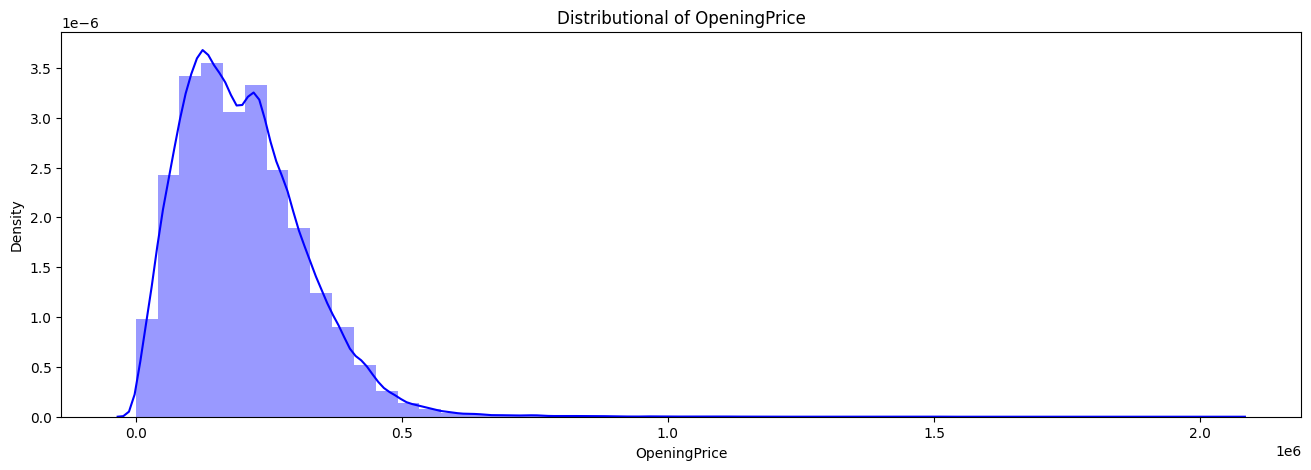

In [71]:
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.distplot(df["OpeningPrice"], color="blue",ax = axes)
plt.title("Distributional of OpeningPrice")